In [1]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingRegressor

warnings.filterwarnings('ignore') # 'once' shows warning just first time it is triggered
# We just use filterwarnings('ignore') to stop warnings from being sown for SKLEARN changes to defaults in upcoming versions

# We'll use boston housing data as an example
#bh = load_boston()
#target = bh.target
#x_data = bh.data

# We will evaluate the models using mean squared error
# Since Python's Sklearn requires scorer to have greater is better property
# We'll use the negated mean squared error as our scorer using make_scorer function
scorer = make_scorer(mean_squared_error, greater_is_better = False)

#Where applicable we'll use the same random seed
rand_state = 748932

# We'll pass an instance or repeatedstratified Kfold to the GridSearchCV
#cv_strategy = KFold(n_splits = 10, shuffle = True, random_state = rand_state)
cv_strategy = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rand_state)

## Preparing the Dataset 

Before we can build a model to predict the DW-Nominate scores for junionr legislators, we must first prepare our dataset. This section reads in the legislator and campaign finance data, join them, and cleans the data for downstream use in a machine learning model. 

In [2]:
# This reads the user data from Github
donationDataLocation = "https://raw.githubusercontent.com/zack-braun/DVA-Project/master/experiments/Donations%20to%20Cand%20by%20Committee.csv"
campaignDF = pd.read_csv(donationDataLocation)
campaignDF.rename({'Candidate_ID':'opensecrets'} , axis = 1, inplace = True)
campaignDF.fillna(0, inplace = True)
#display(campaignDF.sample(5))
#print('The campaign data has', campaignDF.shape[0], 'rows and', campaignDF.shape[1], 'columns')

# This reads in the legislator data
legislatorData = "https://raw.githubusercontent.com/zack-braun/DVA-Project/master/experiments/combinedData.csv"
legislatorDF = pd.read_csv(legislatorData)
legislatorDF['BirthYear'] = legislatorDF.date_of_birth.str.split("-", expand = True)[0]
dropColz = ['index', 'govtrack_id', 'congress', 'district', 'first_name', 'last_name','last_updated', 'date_of_birth',
            'short_title', 'missed_votes', 'middle_name', 'next_election', 'total_votes', 'total_present', 'at_large',
            'office', 'in_office', 'Finance', 'suffix', 'leadership_role', 'senate_class', 'state_rank']
legislatorDF.drop(dropColz , axis = 1, inplace = True)
#display(legislatorDF.sample(5))
#print('The legislator data has', legislatorDF.shape[0], 'rows and', legislatorDF.shape[1], 'columns')


combinedData = pd.merge(legislatorDF, campaignDF, on='opensecrets' , how="inner" )
combinedData.drop(['opensecrets'], axis = 1, inplace = True)
display(combinedData.sample(5))
print('The combined data has', combinedData.shape[0], 'rows and', combinedData.shape[1], 'columns')

target = combinedData['dw_nominate']
x_data = combinedData.copy()
x_data.drop(['dw_nominate'], axis = 1, inplace = True)

,dw_nominate,chamber,gender,missed_votes_pct,party,seniority,state,title,votes_with_party_pct,BirthYear,...,C90017708,C00647701,C00655696,C00473371,C00399865,C00676635,C00545616,C00031054,C00195065,C00679688
277,-0.381,House,F,3.14,D,6,NY,Representative,94.29,1975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,0.520,House,M,0.00,R,12,OH,Representative,96.62,1956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133,0.299,House,M,2.48,R,14,NE,Representative,93.57,1960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,-0.346,House,F,1.40,D,2,FL,Representative,94.39,1957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532,0.466,Senate,M,3.34,R,3,AK,"Senator, 2nd Class",97.24,1964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The combined data has 545 rows and 4336 columns


## Building a Prediction Pipeline

DW-Nominate scores are continuous over their relevant range. Therefore, we will treat this as a regression problem and use several suitable machine learning approaches. As is common in regression problems, we will use cross-validated mean squared error to judge model performance.

Several of the models require that the input data is standardized. For these models we will use sklearn's prediction pipeline capabilities to ensure the standardization occurs as part of our cross-validated model tuning. For the remaining models we will use the un-standardized features in our model.In that case, we will use a different prediction pipeline.

In [3]:
numeric_features = list(x_data._get_numeric_data().columns)
categorical_features = list(x_data.columns.difference(numeric_features))

# We create seperate Pipelines for these columns
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer( transformers = [('num', numeric_transformer, numeric_features),
                                                 ('cat', categorical_transformer, categorical_features)])

# The final step is append the regression model to the prediction pipeline
# This will be handled in each section below

### Support Vector Regression (SVR) 

Support Vector Regression provides a alternative to regular regression. Rather than minimizing squared error as in standard OLS style regression, it is looking to minimize the error while allowing the fitted model to be less sensitive to errrors within a margin (typically referred to as epsilon). As discussed in our final report, past research has used SVR to predict DW-Nominate scores as a function of campaign finance data. Those methods involved the use of a large number of features indicating the amount of donations from different donors. We use similar methods to include the donations from different donors in our implementation of SVR, as well as the other models. We augment these features by also including demographic information about the candidate such as the gender, party, and other attributes.

Since SVR depends on distance calculations (just like support vector classification), the input features are all standardized during the model cross-validation pipeline.

In [4]:
predPipeSVR = Pipeline(steps = [('preprocessor', preprocessor), ('clf', SVR(gamma = 'scale'))])

# We need to tune the parameters c and kernel options:{'linear', 'poly', 'rbf', 'sigmoid'}
parameters = {'clf__kernel':('linear', 'rbf', 'poly', 'sigmoid'), 
              'clf__C':[0.001, 0.01, 0.1, 1, 10, 100], 
              'clf__epsilon':[0.1, 0.3, 0.5, 0.9]}

clf = GridSearchCV(predPipeSVR, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsSVR = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)
# The best parameters searched are: {'clf__C': 0.1, 'clf__epsilon': 0.3, 'clf__kernel': 'linear'}

The best parameters searched are: {'clf__C': 0.1, 'clf__epsilon': 0.3, 'clf__kernel': 'linear'}


### Elastic Net Regresssion

Elastic Net regression uses a weighted average of the Lasso (L1) and Ridge (L2) penalties for regularization as shown in the formula below. 

$$\hat{\beta} = argmin\left( \left(y-X\beta\right)^2 + \lambda*\left(\alpha*\sum{\left|\beta\right|} + \left(1-\alpha\right)*\sum{\beta^2} \right) \right)$$

Both penalties trade bias in the coefficient estimates, which are shrunk toward zero, for reduced model variance, which can improve predictive accuracy. 

When $\alpha=1$ the penalty reduces to the usual Lasso (L1) penalty in terms of the absolute value of the coefficients. This has the effect that some coefficients are zeroed out or removed from the model, resulting in implicit feature selection. On the other hand $\alpha=0$ results in the Ridge (L2) penalty. Since the L2 penalty is a function of the squared coefficients, the individual coefficients are shrunk toward zero but not typically zeroed out. 

The code below tunes the optimal values for alpha (which sklearn call l1_ratio) and lambda (which sklearn confusingly calls alpha).

Since the penalties are a function of the coefficients and these in turn are affected by the scale of the data, each regressor is standardized prior to its inclusion in the model as was the case for the SVR model.



In [5]:
predPipeENET = Pipeline(steps = [('preprocessor', preprocessor), ('clf', ElasticNet(max_iter = 1500, 
                                                                                 random_state = rand_state))])

# Note: that sklearn's alpha penalty is the same as lambda in R's glmnet package
# thus, alpha controls strength of regularization
# Note: sklearn's l1_ratio is same as alpha in glmnet and controls mixing of l1 and l2 penalties
# l1_ratio = 1 runs straight Lasso, while l1_ratio = 0 runs straight ridge regression

parameters = {'clf__alpha':[0.1, 0.5, 1, 3, 5, 10, 100], 'clf__l1_ratio':[0,0.1, 0.25, 0.5, 0.75, 0.9, 1]}
clf = GridSearchCV(predPipeENET, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsENET = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)
#The best parameters searched are: {'clf__alpha': 0.1, 'clf__l1_ratio': 1}

The best parameters searched are: {'clf__alpha': 0.1, 'clf__l1_ratio': 1}


### Random Forest Regressor 

We can also fit a random forest regressor. This works similar to a random forest classification model, except the mean in each leaf is used for prediction.

The code below tunes the maximum number of features to consider for use in making a split, as well as the maximum depth of each tree.

Since the random forest model does not use distance in its optimization or penalties that are a function of the coefficients, it is not necessary to standardize the input features prior to fitting the model.

In [6]:
predPipeRF = Pipeline(steps = [('preprocessor', preprocessor), 
                               ('clf', RandomForestRegressor(n_estimators = 750, random_state = rand_state) )])

parameters = {'clf__max_features':[5, 15, 25, 50, 65, 100, 200], 'clf__max_depth':[1, 3, 5, 8, 10, 15, 20, None]}
clf = GridSearchCV(predPipeRF, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsRFReg = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)
#The best parameters searched are: {'clf__max_depth': None, 'clf__max_features': 200}

The best parameters searched are: {'clf__max_depth': None, 'clf__max_features': 200}


### Gradient Boosted Regression 

We will also try a boosted tree model. Gradient tree boosted regression fits successive regression models to residuals of the previous stage. The prediction function is essentially updated at each iteration as a weighted average of the previous predictive function (combination of trees previous trees) and the current iteration. The weighted combination is controlled by the learning rate. A smaller learning rate indicates that the new tree is given less weight when updating the aggregate prediction. There is a natural trade-off between the learning rate and number of estimators (n_estimators). Smaller learning rates, typically will combine with a larger number of iterations. This analysis uses a learning rate of 0.1 and iteratively fits 100 trees. 

In [11]:
predPipeGBR = Pipeline(steps = [('preprocessor', preprocessor),
                                ('clf', GradientBoostingRegressor(n_estimators = 100, random_state = rand_state,
                                                                 verbose = 1) )])

# We will optimize n_estimators, learning_rate, subsample, max_depth,
parameters = {  'clf__loss':['huber'], 'clf__learning_rate':[0.1],
                'clf__max_depth':[5, 10, 20, 50], 'clf__subsample':[0.75, 0.85, 0.95],
                 'clf__max_features':['sqrt']}

clf = GridSearchCV(predPipeGBR, parameters, scoring = scorer, cv=cv_strategy, n_jobs = -1)
clf.fit(x_data, target)

resultsGBR = clf.cv_results_

print('The best parameters searched are:', clf.best_params_)

#The best parameters searched are: {'clf__learning_rate': 0.1, 'clf__loss': 'huber', 
#'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__subsample': 0.85}

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0964           0.0199            4.02s
         2           0.0811           0.0142            3.97s
         3           0.0683           0.0123            3.87s
         4           0.0561           0.0104            3.89s
         5           0.0465           0.0086            3.62s
         6           0.0401           0.0059            3.66s
         7           0.0320           0.0067            3.64s
         8           0.0273           0.0045            3.54s
         9           0.0229           0.0035            3.49s
        10           0.0191           0.0028            3.38s
        20           0.0037           0.0004            3.09s
        30           0.0012           0.0001            2.66s
        40           0.0004           0.0000            2.20s
        50           0.0002           0.0000            1.75s
        60           0.0002           0.0000            1.34s
       

## Evaluating Model Performance

After tuning each of the regression models we use the cross-validation results to compare model performance. 

-  Step 1: Extract RMSE from each cross-validation fold for tuned model
-  Step 2: Visualize differences in model performance

If we had done repeated cross-validation or used a larger number of folds it would have been possible to perform pairwise T-tests to determine if the best performing model was statistically significantly better than the other models. We leave this excercise, as well as an exploration into the stacking of these individual models into a meta-learner for future research.

SVR RMSE: [0.2689461  0.26815295 0.25785838 0.23125239 0.25745251 0.2580271
 0.35238851 0.24243189 0.29076429 0.30978706]
Elastic Net RMSE: [0.20783432 0.29571602 0.23938096 0.21827273 0.2534498  0.22656934
 0.25213699 0.21083999 0.49157297 0.27942079]
Random Forest RMSE: [0.10208924 0.12448825 0.11309393 0.0899462  0.12156351 0.10774216
 0.10383605 0.09195579 0.0841575  0.13701494]
Gradient Boosted Regression Tree RMSE: [0.11730779 0.12864235 0.11998696 0.11283089 0.11651257 0.12716695
 0.13677079 0.11646764 0.10051603 0.14513345]


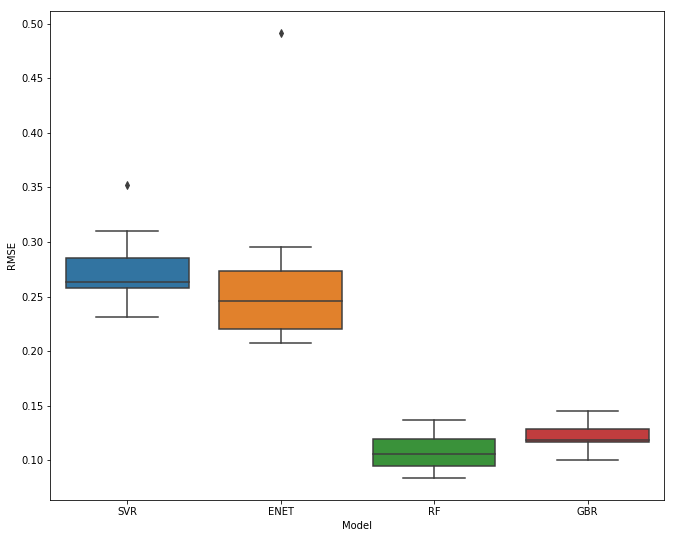

In [13]:
splitz = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 
          'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score']

rmse = {}
# Get RMSE for SVR Model
minSVRScoreIdx = np.argmax(resultsSVR['mean_test_score'])
rmse['SVR'] = np.array([ np.sqrt(-resultsSVR[split][minSVRScoreIdx]) for split in splitz ])
print('SVR RMSE:', rmse['SVR'])

# Get RMSE for Elastic Net Model
minENETScoreIdx = np.argmax(resultsENET['mean_test_score'])
rmse['ENET'] = np.array([ np.sqrt(-resultsENET[split][minENETScoreIdx]) for split in splitz ])
print('Elastic Net RMSE:', rmse['ENET'])

# Get RMSE for Random Forest Regression Model
minRFRegScoreIdx = np.argmax(resultsRFReg['mean_test_score'])
rmse['RF'] = np.array([ np.sqrt(-resultsRFReg[split][minRFRegScoreIdx]) for split in splitz ])
print('Random Forest RMSE:', rmse['RF'])

# Get RMSE for Gradient Boosted Regression Tree
minGBRScoreIdx = np.argmax(resultsGBR['mean_test_score'])
rmse['GBR'] = np.array([ np.sqrt(-resultsGBR[split][minGBRScoreIdx]) for split in splitz ])
print('Gradient Boosted Regression Tree RMSE:', rmse['GBR'])



rmse_df = pd.DataFrame(rmse)
rmse_df['Fold'] = rmse_df.index + 1
rmse_df_long = pd.melt(rmse_df, id_vars = ['Fold'], var_name = 'Model', value_name = 'RMSE')
#f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.boxplot( x = 'Model', y = 'RMSE', data = rmse_df_long)
fig = ax.get_figure()
fig.savefig("C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/ProjectpredJuniorLegisDW.png")

Based on this example code we can conclude that the Elastic Net model had the worst out of sample performance and is probably not the best candidate for use. The Support Vector Regression, Gradient Boosted Regression Tree and Random Forest models had similar mean test set error; however, the dispersion of their error across the folds varied. 

Given its quick time to fit, the Random Forest Regression seems like a good candidate to use.

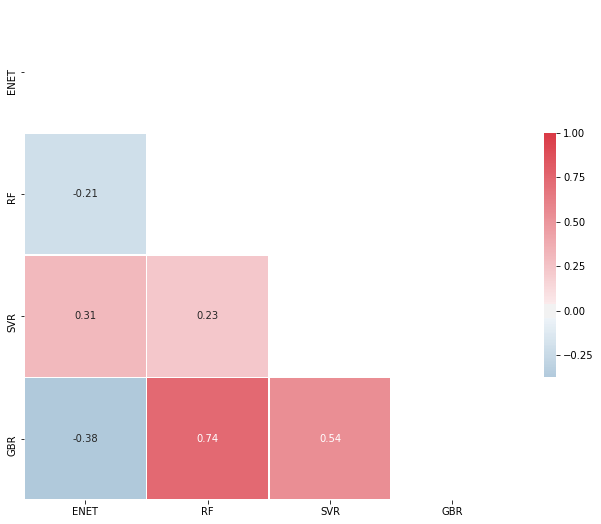

In [15]:

#corr = rmse_df[['ENET', 'GBR', 'RF', 'SVR']].corr()

corr = rmse_df[['ENET', 'RF', 'SVR', 'GBR']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, n=9, as_cmap = True)
f, ax = plt.subplots(figsize=(11, 9))


display(sns.heatmap(corr, cmap=cmap, mask = mask, vmax=1, center=0, square=True, 
                    linewidths=.5, annot=True, cbar_kws={"shrink": .5}))

Given that the models are relatively uncorrelated (with the exception of the support vector regression and elastic net), we can probably improve accuracy by averaging our predictions. It has been shown that Elastic Net and Support Vector Regression are related. Therefore, we include only one of them in the stacked model. Since the Elastic Net model had negative correlation with the Random Forest Regressor, we choose that model to include in a model stack. However, we leave that for a future excercise.

In [ ]:
from mlxtend.regressor import StackingRegressor
import warnings
warnings.filterwarnings('once')

predPipeRF = Pipeline(steps = [('preprocessor', preprocessor), 
                                ('clf', RandomForestRegressor(n_estimators= 500, max_features = 200, 
                                                              max_depth = None, random_state = rand_state))])

predPipeENET = Pipeline(steps = [('preprocessor', preprocessor), 
                                 ('clf', ElasticNet(max_iter = 1500, alpha = 0.1, 
                                                    l1_ratio = 1, random_state = rand_state))])

predPipeGBR = Pipeline(steps = [('preprocessor', preprocessor),
                                ('clf', GradientBoostingRegressor(n_estimators = 100, random_state = rand_state,
                                                                 learning_rate = 0.1, max_features = 'sqrt', 
                                                                 subsample = 0.85, max_depth = 10, loss = 'huber') )])

predPipeSVR = Pipeline(steps = [('preprocessor', preprocessor), 
                                ('clf', SVR(gamma = 'scale', C = 0.1, epsilon = 0.3, kernel = 'linear'))])

rfStack = RandomForestRegressor(n_estimators = 500, random_state = rand_state, max_features = 'auto')

regressors = [predPipeRF, predPipeENET, predPipeGBR, predPipeSVR]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=rfStack)

parameters = {'meta-randomforestregressor__max_depth':[1, 3, 5, None]}


grid = GridSearchCV(estimator=stregr, param_grid=parameters, scoring = scorer, cv=cv_strategy)
grid.fit(x_data, target)

resultsStack = grid.cv_results_

minStackScoreIdx = np.argmax(resultsStack['mean_test_score'])
rmse['Stack'] = np.array([ np.sqrt(-resultsStack[split][minStackScoreIdx]) for split in splitz ])
print('Stacked Models:', rmse['Stack'])

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rkuhn\App

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklea

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklea

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anacon

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\rkuhn\App

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-pac

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklea

C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\rkuhn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklea

As we can see in the chart below, after stacking the models there is a slight improvement in root mean square error. Therefore, we elect to use the results of this modeling approach.

In [ ]:

rmse_df = pd.DataFrame(rmse)
rmse_df['Fold'] = rmse_df.index + 1
rmse_df.drop(['RF_Limited_Features'], axis = 1, inplace = True)
rmse_df_long = pd.melt(rmse_df, id_vars = ['Fold'], var_name = 'Model', value_name = 'RMSE')
#f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.boxplot( x = 'Model', y = 'RMSE', data = rmse_df_long)
fig = ax.get_figure()
fig.savefig("C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/Project/predJuniorLegisDWStacked.png")

In [ ]:
missingDWNominateFile = "C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/Project/missingDW.csv"
missingDW = pd.read_csv(missingDWNominateFile)
missingDW.drop(['Unnamed: 0', 'dw_nominate'], axis = 1, inplace = True )
print(missingDW.columns)
missingDW = pd.merge(missingDW, campaignDF, on='opensecrets' , how="left" )
print(missingDW.shape)
print(missingDW.columns)
missingDW.drop(['opensecrets', 'govtrack_id'], axis = 1, inplace = True)
missingDW = missingDW.fillna(0, axis = 1)
display(missingDW.head())
# We make our prediction using the stacked regressor

rfStack = RandomForestRegressor(n_estimators = 500, random_state = rand_state, max_features = 'auto', max_depth = 5)

regressors = [predPipeRF, predPipeENET, predPipeGBR, predPipeSVR]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=rfStack)

stregr.fit(x_data, target)
predictedDW = stregr.predict(missingDW)

display(predictedDW)

In [ ]:
display(predictedDW)

DWNom = pd.Series(predictedDW)
missingDW['dw_nominate'] = DWNom
missingDW.to_csv('C:/Users/rkuhn/Documents/Courses/DataandVisualAnalytics/Project/missingDWpredictions.csv')